In [1]:
# imports 
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
import h5_utilities_module as h5u
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from copy import deepcopy
from joblib import Parallel, delayed
from tqdm import tqdm
from pathlib import Path
import h5py
import pingouin as pg
import warnings
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)

In [2]:
# functions
def get_labelled_posteriors(indata, labels):

    '''
    INPUTS:
    indata = posterior probabilites from a classifier with the shape
            n_trials x n_timesteps x n_classes
        
    labels = 1d array with len(n_trials) - these labels ought
            to correspond to class numbers (layers in indata)

    OUTPUT:
        labelled_posteriors = posterior probabilities associated with the
        classes in the labels input for each timestep and trial
    '''

    n_trials, n_times, n_classes = indata.shape
    class_lbls = np.unique(labels)
    class_lbls = class_lbls[~np.isnan(class_lbls)]

    # initialize output
    labelled_posteriors = np.zeros(shape = (n_trials, n_times))

    for ix, lbl in enumerate(class_lbls):
        
        # find trials where this label was chosen
        labelled_posteriors[labels == lbl,:] = indata[labels == lbl,:,int(ix)]
        
    return labelled_posteriors


def pull_balanced_train_set(trials2balance, params2balance):
    '''
    INPUTS:
    trials2balance   - ***logical array*** of the trials you want to balance
    params2balance   - ***list*** where each element is a vector of categorical
                        parameters to balance (e.g. choice value and side)
                        each element of params2balance must have the same
                        number of elements as trials2balance
    OUTPUTS:
    train_ix         - trial indices of a fully balanced training set
    leftover_ix      - trial indices of trials not included in train_ix
    '''

    # Find the indices where trials are selected to balance
    balance_indices = np.where(trials2balance)[0]

    # Create an array of parameters to balance
    params_array = np.array(params2balance).T

    # Find unique combinations and their counts
    p_combos, p_counts = np.unique(params_array[balance_indices], axis=0, return_counts=True)

    # Determine the minimum count for a balanced set
    n_to_keep = np.min(p_counts)

    # Initialize arrays to mark selected and leftover trials
    train_ix = np.zeros(len(trials2balance), dtype=bool)
    leftover_ix = np.zeros(len(trials2balance), dtype=bool)

    # Select a balanced number of trials for each unique parameter combination
    for combo in p_combos:
        # Find indices of trials corresponding to the current combination
        combo_indices = np.where((params_array == combo).all(axis=1) & trials2balance)[0]

        # Shuffle the indices
        np.random.shuffle(combo_indices)

        # Select n_to_keep trials and mark them as part of the training set
        train_ix[combo_indices[:n_to_keep]] = True

        # Mark the remaining trials as leftovers
        leftover_ix[combo_indices[n_to_keep:]] = True

    return train_ix, leftover_ix


def random_prop_of_array(inarray, proportion):
    '''
    INPUTS
    inarray = logical/boolean array of indices to potentially use later
    proportion = how much of inarray should randomly be selected

    OUTPUT
    out_array = logical/boolean that's set as 'true' for a proportion of the 
                initial 'true' values in inarray
    '''

    out_array = np.zeros(shape = (len(inarray), ))

    # find where inarray is true and shuffle those indices
    shuffled_ixs = np.random.permutation(np.asarray(np.where(inarray)).flatten())

    # keep only a proportion of that array
    kept_ix = shuffled_ixs[0: round(len(shuffled_ixs)*proportion)]

    # fill in the kept indices
    out_array[kept_ix] = 1

    # make this a logical/boolean
    out_array = out_array > 0

    return out_array


def pull_from_h5(file_path, data_to_extract):
    try:
        with h5py.File(file_path, 'r') as file:
            # Check if the data_to_extract exists in the HDF5 file
            if data_to_extract in file:
                data = file[data_to_extract][...]  # Extract the data
                return data
            else:
                print(f"'{data_to_extract}' not found in the file.")
                return None
    except Exception as e:
        print(f"An error occurred: {e}")
        return None
    
def list_hdf5_data(file_path):
    try:
        with h5py.File(file_path, 'r') as file:
            print(f"Datasets in '{file_path}':")
            for dataset in file:
                print(dataset)
    except Exception as e:
        print(f"An error occurred: {e}")


def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val


def get_ch_and_unch_pps(in_pp, bhv, ch_val, unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        ch_val (ndarray): vector indicating the class that is ultimately chosen
        unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        ch_pp (ndarray): vector of the postior at each point in time for each trial's chosen option
        unch_pp (ndarray): vector of the postior at each point in time for each trial's unchosen option
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    ch_pp = np.zeros(shape=(n_trials, n_times))
    unch_pp = np.zeros(shape=(n_trials, n_times))

    # loop over each trial
    for t in range(n_trials):
        
        # get the chosen and unchosen PPs
        ch_pp[t, :] = in_pp[t, :, int(ch_val[t]-1)]
        unch_pp[t, :] = in_pp[t, :, int(unch_val[t]-1)]
        
    # set the forced choice unchosen pps to nans, since there was only 1 option
    unch_pp[bhv['forced'] == 1, :] = np.nan
    
    return ch_pp, unch_pp


def get_alt_ch_and_unch_pps(in_pp, bhv, s_ch_val, s_unch_val):
    """Gets the posteriors associated with the chosen and unchosen classes

    Args:
        in_pp (ndarray): array of posteriors (n_trials x n_times x n_classes)
        bhv (dataframe): details of each trial
        s_ch_val (ndarray): vector indicating the class that is ultimately chosen
        s_unch_val (ndarray): vector indicating the class that was ultimately not chosen

    Returns:
        alt_ch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
        alt_unch_pp (ndarray): vector of the postior at each point in time for the alternative value in the other state
    """

    # select the chosen and unchosen values 
    n_trials, n_times, n_classes = np.shape(in_pp)
    alt_ch_pp = np.zeros(shape=(n_trials, n_times))
    alt_unch_pp = np.zeros(shape=(n_trials, n_times))

    alt_ch_val = np.zeros_like(s_ch_val)
    alt_unch_val = np.zeros_like(s_unch_val)
    
    alt_ch_val[bhv['state'] == 1] = 8 - s_ch_val[bhv['state'] == 1] + 1
    alt_ch_val[bhv['state'] == 2] = 8 - s_ch_val[bhv['state'] == 2] + 1

    alt_unch_val[bhv['state'] == 1] = 8 - s_unch_val[bhv['state'] == 1] + 1
    alt_unch_val[bhv['state'] == 2] = 8 - s_unch_val[bhv['state'] == 2] + 1

    for t in range(n_trials):
        
        alt_ch_pp[t, :] = in_pp[t, :, int(alt_ch_val[t]-1)]
        alt_unch_pp[t, :] = in_pp[t, :, int(alt_unch_val[t]-1)]

    # set the alternative values to nans for state 3, since there were no alternatives
    alt_ch_pp[bhv['state'] == 3] = np.nan
    alt_unch_pp[bhv['state'] == 3] = np.nan

    return alt_ch_pp, alt_unch_pp

def find_candidate_states(indata, n_classes, temporal_thresh, mag_thresh):
    """Finds periods where decoded posteriors are twice their noise level.

    Args:
        indata (ndarray): 2d array of posterior probabilities associated with some decoder output.
        n_classes (int): How many classes were used in the decoder?
        temporal_thresh (int): Number of contiguous samples that must be above a threshold to be a real state (typically 2).
        mag_thresh (flat): how many times the noise level must a state be? (e.g. 2 = twice the noise level)

    Returns:
        state_details (ndarray): 2d array where each row details when a state occurred [trial_num, time_in_trial, state_length].
        state_array (ndarray): 2d array the same size as indata. It contains 1 in all locations where there were states and 0s everywhere else.
    """
    state_details = np.array([])
    state_array = np.zeros_like(indata)
    
    state_magnitude_thresh = (1 / n_classes) * mag_thresh

    for t in range(indata.shape[0]):
        state_len, state_pos, state_type = find_1dsequences(indata[t, :] > state_magnitude_thresh)
        state_len = state_len[state_type == True]
        state_pos = state_pos[state_type == True]

        for i in range(len(state_len)):
            state_details = np.concatenate((state_details, np.array([t, state_pos[i], state_len[i]])))

    state_details = state_details.reshape(-1, 3)
    state_details = state_details[state_details[:, 2] > temporal_thresh, :]

    # Update state_array using state_details information
    for j in range(len(state_details)):
        state_trial, state_start, state_len = state_details[j].astype(int)
        state_array[state_trial, state_start:(state_start + state_len)] = 1

    return state_details, state_array

def moving_average(x, w, axis=0):
    '''
    Moving average function that operates along specified dimensions of a NumPy array.

    Parameters:
    - x (numpy.ndarray): Input array.
    - w (int): Size of the window to convolve the array with (i.e., smoothness factor).
    - axis (int): Axis along which to perform the moving average (default is 0).

    Returns:
    - numpy.ndarray: Smoothed array along the specified axis with the same size as the input array.
    '''
    x = np.asarray(x)  # Ensure input is a NumPy array
    if np.isnan(x).any():
        x = np.nan_to_num(x)  # Replace NaN values with zeros

    if axis < 0:
        axis += x.ndim  # Adjust negative axis value

    kernel = np.ones(w) / w  # Create kernel for moving average

    # Pad the array before applying convolution
    pad_width = [(0, 0)] * x.ndim  # Initialize padding for each axis
    pad_width[axis] = (w - 1, 0)  # Pad along the specified axis (left side)
    x_padded = np.pad(x, pad_width, mode='constant', constant_values=0)

    # Apply 1D convolution along the specified axis on the padded array
    return np.apply_along_axis(lambda m: np.convolve(m, kernel, mode='valid'), axis, x_padded)

def find_1dsequences(inarray):
        ''' 
        run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) 
        '''
        ia = np.asarray(inarray)                # force numpy
        n = len(ia)
        if n == 0: 
            return (None, None, None)
        else:
            y = ia[1:] != ia[:-1]                 # pairwise unequal (string safe)
            i = np.append(np.where(y), n - 1)     # must include last element 
            lens = np.diff(np.append(-1, i))      # run lengths
            pos = np.cumsum(np.append(0, lens))[:-1] # positions
            return(lens, pos, ia[i])
  
        
def shuffle_along_axis(arr, axis):
    return np.apply_along_axis(np.random.permutation, axis, arr)


In [3]:
# where are the data?
data_dir = 'C:/Users/thome/Documents/PYTHON/OFC-CdN 3 state self control/files_for_decoder/'

# get the names/paths of the files
data_files = h5u.find_h5_files(data_dir)

In [4]:
subject = np.zeros((len(data_files), ))

# define how many bootstraps we will run and pre-allocate arrays for accumulating results into
n_boots = 1000
neuron_step_size = 5 # define how many neurons we will grab for each step
n_units_in_decoder = np.arange(neuron_step_size, neuron_step_size*105, neuron_step_size)

ofc_decoder_results = np.zeros((len(data_files), len(n_units_in_decoder)))
cdn_decoder_results = np.zeros((len(data_files), len(n_units_in_decoder)))

ofc_decoder_results[:] = np.nan
cdn_decoder_results[:] = np.nan

In [ ]:
for f_ix, this_file in enumerate(data_files):
    
    f_name = Path(this_file).stem
    print(f_name)

    if 'D' in f_name:
        s = 0
    else:
        s = 1
    
    subject[f_ix] = s


    # pull the data for this file
    # access the data for this session
    ofc_firing_rates = h5u.pull_from_h5(this_file, 'OFC_zFR')
    cdn_firing_rates = h5u.pull_from_h5(this_file, 'CdN_zFR')
                            
    # figure out how many neurons we have
    n_OFC = h5u.pull_from_h5(this_file, 'OFC_zFR').shape[2]
    n_CdN = h5u.pull_from_h5(this_file, 'CdN_zFR').shape[2]
    brain_areas = np.concatenate([np.zeros(shape=n_CdN, ), np.ones(shape=n_OFC, )]).astype(int)

    # pull out the time step index and the behavior
    ts = h5u.pull_from_h5(this_file, 'ts')
    bhv = pd.read_hdf(this_file, key='bhv')

    # make sure the behavioral data has the same number of trials as the firing rates
    if len(bhv) > len(ofc_firing_rates):
        bhv = bhv.loc[0 :len(ofc_firing_rates)-1]

    # set any nan values to zero (necessary for the decoder)
    ofc_firing_rates = np.nan_to_num(ofc_firing_rates, nan=0)
    cdn_firing_rates = np.nan_to_num(cdn_firing_rates, nan=0)

    # get indices of the choice period
    pics_on = np.argwhere(ts == 25)[0][0]
    pics_end = np.argwhere(ts == 400)[0][0]

    # get the mean firing rate for the choice period for both brain areas
    ofc_choice_frs = np.mean(ofc_firing_rates[:,pics_on:pics_end,:], axis=1)
    cdn_choice_frs = np.mean(cdn_firing_rates[:,pics_on:pics_end,:], axis=1)

    # get the labels associated with each unique state-value pair
    ch_val, unch_val = get_ch_and_unch_vals(bhv)
    s_ch_val = ch_val.copy()
    s_unch_val = unch_val.copy()

    s_ch_val[bhv['state'] == 2] = s_ch_val[bhv['state'] == 2] + 4
    s_ch_val[bhv['state'] == 3] = s_ch_val[bhv['state'] == 3] + 8
    s_unch_val[bhv['state'] == 2] = s_unch_val[bhv['state'] == 2] + 4
    s_unch_val[bhv['state'] == 3] = s_unch_val[bhv['state'] == 3] + 8

    n_vals = len(np.unique(s_ch_val))

    # pre-allocate arrays for this file's decoders
    OFC_acc = np.zeros((n_boots, len(n_units_in_decoder))) 
    CdN_acc = np.zeros((n_boots, len(n_units_in_decoder))) 
    OFC_acc[:] = np.nan
    CdN_acc[:] = np.nan

    # loop over bootstraps
    for b in tqdm(range(n_boots)):

        # loop over numbers of neurons to include in the decoder
        for n_units_ix in range(len(n_units_in_decoder)):

            # partition the data into training and testing sets
            valid_trials = (bhv['forced'] == 1) | (bhv['n_sacc'] == 1)
            train_ix = random_prop_of_array(valid_trials, .9)
            train_labels = s_ch_val[train_ix]

            test_trials = ~train_ix & valid_trials

            # check if there were enough OFC units to run this part of the bootstrap
            if n_OFC >= n_units_in_decoder[n_units_ix]:

                neurons2use = np.random.randint(0, n_OFC, n_units_in_decoder[n_units_ix])

                these_ofc_neurons = ofc_choice_frs[:, neurons2use]

                # initialize classifier
                OFC_lda = LinearDiscriminantAnalysis()

                # train the classifier
                OFC_lda.fit(these_ofc_neurons[train_ix, :], train_labels)
                
                # test the classifier
                OFC_acc[b, n_units_ix] = np.mean(OFC_lda.predict(these_ofc_neurons[test_trials, :]) == s_ch_val[test_trials])


            # check if there were enough CdN units to run this part of the bootstrap
            if n_CdN >= n_units_in_decoder[n_units_ix]:

                neurons2use = np.random.randint(0, n_CdN, n_units_in_decoder[n_units_ix])

                these_cdn_neurons = cdn_choice_frs[:, neurons2use]

                # initialize classifier
                #CdN_lda = LogisticRegression(max_iter=1000)
                CdN_lda = LinearDiscriminantAnalysis()

                # train the classifier
                CdN_lda.fit(these_cdn_neurons[train_ix, :], train_labels)
                
                # test the classifier
                CdN_acc[b, n_units_ix] = np.mean(CdN_lda.predict(these_cdn_neurons[test_trials, :]) == s_ch_val[test_trials])

    # now we need to store the results
    ofc_decoder_results[f_ix, :] = np.nanmean(OFC_acc, axis=0)
    cdn_decoder_results[f_ix, :] = np.nanmean(CdN_acc, axis=0)

D20231219_Rec05


100%|██████████| 1000/1000 [43:47<00:00,  2.63s/it]


D20231221_Rec06


100%|██████████| 1000/1000 [29:53<00:00,  1.79s/it]


D20231224_Rec07


100%|██████████| 1000/1000 [19:06<00:00,  1.15s/it]


D20231227_Rec08


100%|██████████| 1000/1000 [14:56<00:00,  1.11it/s]


K20240707_Rec06


100%|██████████| 1000/1000 [28:22<00:00,  1.70s/it]


K20240710_Rec07


100%|██████████| 1000/1000 [4:32:08<00:00, 16.33s/it]     


K20240712_Rec08


100%|██████████| 1000/1000 [25:25<00:00,  1.53s/it]


K20240715_Rec09


100%|██████████| 1000/1000 [46:42<00:00,  2.80s/it]


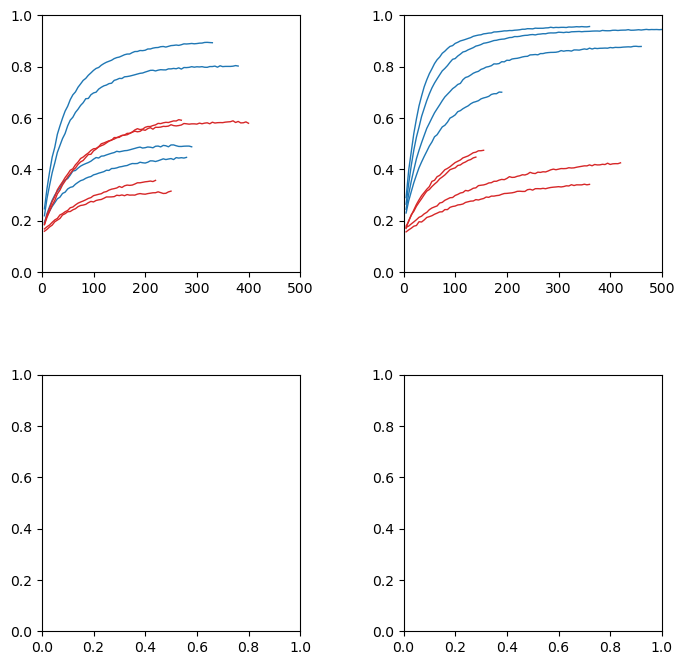

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

ax[0,0].plot(n_units_in_decoder, ofc_decoder_results[subject == 0, :].T, color='tab:blue', linewidth = 1)
ax[0,0].plot(n_units_in_decoder, cdn_decoder_results[subject == 0, :].T, color='tab:red', linewidth = 1)
ax[0,0].set_xlim((0, 500))
ax[0,0].set_ylim((0, 1))

ax[0,1].plot(n_units_in_decoder, ofc_decoder_results[subject == 1, :].T, color='tab:blue', linewidth = 1)
ax[0,1].plot(n_units_in_decoder, cdn_decoder_results[subject == 1, :].T, color='tab:red', linewidth = 1)
ax[0,1].set_xlim((0, 500))
ax[0,1].set_ylim((0, 1))

#fig.savefig('neuron_dropping_fig.svg')
